In [1]:
import secrets
import pandas as pd
import numpy as np # type: ignore
import seaborn as sns
import plotly.io as pio

from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend
from random import randint, uniform

sns.set(style="whitegrid")

In [2]:
from dataclasses import dataclass, field
from typing import TypedDict, List, Callable, NamedTuple


from model.utils import default, update_from_signal
import visualizations

In [3]:

from model.agents_class import AgentStake
from model.rewards import calculate_reward_allocation
from model.stochastic_processes import create_stochastic_avail_price_process, plot_price

from real_data_fetcher import fetch

from config.psub import psub
from config.params import FusionParams

# Price Traj Generation

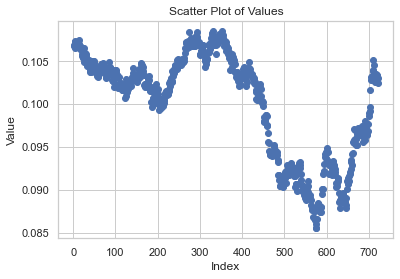

0.08551803146752857


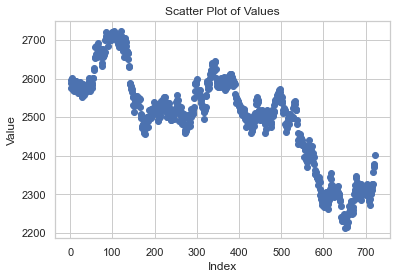

2211.2099809185775


In [4]:
# types
Run = int
Timestep = int

avl_price_samples = create_stochastic_avail_price_process(price_traj_type='concave', minimum_avl_price=0.05, target_avg=0.1, maximum_avl_price=1.0)
plot_price(avl_price_samples)
print(min(avl_price_samples))

eth_price_samples = create_stochastic_avail_price_process(price_traj_type='concave', minimum_avl_price=1500, target_avg=2500, maximum_avl_price=3000)
plot_price(eth_price_samples)
print(min(eth_price_samples))



In [7]:
# avl_price_samples, eth_price_samples, Timestep = fetch(symbol_avl='hawk')

# plot_price(avl_price_samples) 
# print(min(avl_price_samples))

# plot_price(eth_price_samples) 
# print(min(eth_price_samples))

# Setup

In [5]:
AVL_initial_price = avl_price_samples[0]
ETH_initial_price = eth_price_samples[0]
print(AVL_initial_price)

0.10676951015148498


In [6]:
# Fixed parameters
def fixed_params(total_supply = 10_000_000_000, avl_price = AVL_initial_price):
    total_fdv = total_supply * avl_price
    return total_fdv

init_total_fdv = fixed_params(avl_price = AVL_initial_price)

In [7]:
constants = {
    "total_supply": 10_000_000_000,
    "init_total_fdv": init_total_fdv,
    "native_staking_ratio": 0.3,
    "upper_rewards_to_fusion_pct": 0.5,
}




In [8]:
## create maxi agents

agents = AgentStake.create_maxi_agents(
    target_composition={'AVL': 1, 'ETH': 0, 'BTC': 0},  # 50% AVL, 30% ETH, 20% BTC
    total_tvl=0  # $1M total TVL
)

In [10]:
rewards_result = calculate_reward_allocation(
    constants=constants,
    avl_price=0.1,
    total_tvl=250e6,
    avl_stake_pct=0.15,
    target_avl_yield=0.15,
    target_eth_yield=0.035
)

assert rewards_result["capped"] == False


fusion_pct: 0.3598322928760246


# Simulation

In [11]:
# system parameters
parameters = FusionParams(
    avl_price_samples=avl_price_samples, eth_price_samples=eth_price_samples, 
    rewards_result=rewards_result, 
    agents=agents).__dict__

params = parameters


In [12]:
parameters

{'avl_price_samples': [np.float64(0.10676951015148498),
  np.float64(0.10689099576409197),
  np.float64(0.10728858465949258),
  np.float64(0.10740150726296536),
  np.float64(0.106567418000266),
  np.float64(0.10701388457284358),
  np.float64(0.10719435355969215),
  np.float64(0.10680482061262321),
  np.float64(0.10706362982606424),
  np.float64(0.10719700016925325),
  np.float64(0.10728964051301718),
  np.float64(0.107228337484673),
  np.float64(0.1074676372804474),
  np.float64(0.10696309506087712),
  np.float64(0.10679119034385061),
  np.float64(0.1064343246710196),
  np.float64(0.10670428803982765),
  np.float64(0.10665019326722938),
  np.float64(0.10640361811723056),
  np.float64(0.10587337931708303),
  np.float64(0.10564746868818117),
  np.float64(0.10557550248007341),
  np.float64(0.10533913670964004),
  np.float64(0.10601293797252931),
  np.float64(0.1065202557128935),
  np.float64(0.10487213555091186),
  np.float64(0.10580781990173194),
  np.float64(0.10583311882586101),
  np.f

In [16]:
# initial conditions

initial_conditions = {
    "timestep": 0,
    
    "AVL_security_pct": 0 * 100,
    "ETH_security_pct": 0 * 100,
    "total_security": 0,
    "total_fdv": init_total_fdv,

    "staking_ratio_all": constants["native_staking_ratio"],
    "staking_ratio_avl_fusion": 0.0,
    "staking_ratio_eth_fusion": 0.0,
    
    "inflation_rate": rewards_result["init_inflation_rate"],
    "total_annual_inflation_rewards": rewards_result["total_inflation_rewards"],
    "total_annual_rewards_fusion": rewards_result["required_rewards"],

    "agents": agents,

    "avg_yield": 0,
    "yield_pcts": {"avl": 0, "eth": 0},
    "avl_rewards_allocation": rewards_result["avl_rewards_pct"],

}






In [17]:
# run simulation

model = Model(
    initial_state=initial_conditions,
    state_update_blocks=psub,
    params=params
)

simulation=Simulation(model=model, timesteps=300, runs=1)
experiment = Experiment([simulation])
experiment.engine = Engine(deepcopy=True, backend=Backend.SINGLE_PROCESS)
results  = experiment.run()
df= pd.DataFrame(results)


[COLD START] new_avail_deposit is 0.0
[COLD START] new_eth_deposit is 0.0
[COLD START] agents_avl_balance is [0. 0.]
[COLD START] AVL_stake is [0. 0.]
[COLD START] AVL_stake is [np.float64(0.0), np.float64(0.0)]
[COLD START] agents_eth_balance is [0. 0.]
[COLD START] ETH_stake is [0. 0.]
[COLD START] ETH_stake is [np.float64(0.0), np.float64(0.0)]
ETH_security_pct 0.0
AVL_security_pct 100.0
total_security 0.0
[DEBUG] eth stake is [np.float64(0.0), np.float64(0.0)]
[DEBUG] avl stake is [np.float64(0.0), np.float64(0.0)]
[COLD START] new_avail_deposit is 1000000000.0
[COLD START] new_eth_deposit is 0.0
[COLD START] agents_avl_balance is [0.00000000e+00 9.35532495e+09]
[COLD START] AVL_stake is [0.00000000e+00 9.35532495e+09]
[COLD START] AVL_stake is [np.float64(0.0), np.float64(998863462.6168596)]
[COLD START] agents_eth_balance is [0. 0.]
[COLD START] ETH_stake is [0. 0.]
[COLD START] ETH_stake is [np.float64(0.0), np.float64(0.0)]
ETH_security_pct 0.0
AVL_security_pct 100.0
total_secu

 nan
[DEBUG] eth stake is [np.float64(nan), np.float64(nan)]
[DEBUG] avl stake is [np.float64(nan), np.float64(nan)]
[COLD START] new_avail_deposit is nan
[COLD START] new_eth_deposit is nan
[COLD START] agents_avl_balance is [nan nan]
[COLD START] AVL_stake is [nan nan]
[COLD START] AVL_stake is [np.float64(nan), np.float64(nan)]
[COLD START] agents_eth_balance is [nan nan]
[COLD START] ETH_stake is [nan nan]
[COLD START] ETH_stake is [np.float64(nan), np.float64(nan)]
ETH_security_pct nan
AVL_security_pct nan
total_security nan
[DEBUG] eth stake is [np.float64(nan), np.float64(nan)]
[DEBUG] avl stake is [np.float64(nan), np.float64(nan)]
[COLD START] new_avail_deposit is nan
[COLD START] new_eth_deposit is nan
[COLD START] agents_avl_balance is [nan nan]
[COLD START] AVL_stake is [nan nan]
[COLD START] AVL_stake is [np.float64(nan), np.float64(nan)]
[COLD START] agents_eth_balance is [nan nan]
[COLD START] ETH_stake is [nan nan]
[COLD START] ETH_stake is [np.float64(nan), np.float64(

/Users/amber/Desktop/Simulation/Avail-Fusion-CryptoEcon/model/basic_model.py:183: RuntimeWarning: invalid value encountered in scalar divide
  "staking_ratio_avl": AVL_stake.upper_bound / total_security,
/Users/amber/Desktop/Simulation/Avail-Fusion-CryptoEcon/model/basic_model.py:184: RuntimeWarning: invalid value encountered in scalar divide
  "staking_ratio_eth": ETH_stake.upper_bound / total_security


[COLD START] AVL_stake is [nan nan]
[COLD START] AVL_stake is [np.float64(nan), np.float64(nan)]
[COLD START] agents_eth_balance is [nan nan]
[COLD START] ETH_stake is [nan nan]
[COLD START] ETH_stake is [np.float64(nan), np.float64(nan)]
ETH_security_pct nan
AVL_security_pct nan
total_security nan
[DEBUG] eth stake is [np.float64(nan), np.float64(nan)]
[DEBUG] avl stake is [np.float64(nan), np.float64(nan)]
[COLD START] new_avail_deposit is nan
[COLD START] new_eth_deposit is nan
[COLD START] agents_avl_balance is [nan nan]
[COLD START] AVL_stake is [nan nan]
[COLD START] AVL_stake is [np.float64(nan), np.float64(nan)]
[COLD START] agents_eth_balance is [nan nan]
[COLD START] ETH_stake is [nan nan]
[COLD START] ETH_stake is [np.float64(nan), np.float64(nan)]
ETH_security_pct nan
AVL_security_pct nan
total_security nan
[DEBUG] eth stake is [np.float64(nan), np.float64(nan)]
[DEBUG] avl stake is [np.float64(nan), np.float64(nan)]
[COLD START] new_avail_deposit is nan
[COLD START] new_et

In [18]:
print(df)
df.to_csv('simulation_results.csv', index=False, encoding='utf-8')

      timestep  avl_price    eth_price  AVL_security_pct  ETH_security_pct  \
0            0   0.106770  2574.578493             100.0               0.0   
1            1   0.106770  2574.578493             100.0               0.0   
2            1   0.106770  2574.578493             100.0               0.0   
3            1   0.106770  2574.578493             100.0               0.0   
4            1   0.106770  2574.578493             100.0               0.0   
...        ...        ...          ...               ...               ...   
2096       300   0.105758  2598.448251               NaN               NaN   
2097       300   0.105758  2598.448251               NaN               NaN   
2098       300   0.105758  2598.448251               NaN               NaN   
2099       300   0.105758  2598.448251               NaN               NaN   
2100       300   0.105758  2598.448251               NaN               NaN   

      total_security     total_fdv  staking_ratio_all  staking_

In [19]:
visualizations.plot_token_price_per_subset(
    df,
    scenario_names={
        0: "downside",
    }
)

In [20]:

fig= visualizations.plot_security_pct(
    df
)
pio.show(fig)


In [21]:
fig= visualizations.plot_total_security(
    df
)
pio.show(fig)

In [22]:
fig = visualizations.plot_avg_overall_yield(
    df
)
pio.show(fig)


In [23]:
fig = visualizations.plot_yield_pct(
    df, init_agent_eth_alloc
)
pio.show(fig)

In [24]:
fig= visualizations.plot_staking_ratio_inflation_rate(
    df
)
pio.show(fig)